In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 48.6 MB/s 
     |████████████████████████████████| 103 kB 61.7 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df, set_num):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        vc = data.loc[data['set'] == set_num, col].value_counts() / sum(data['set'] == set_num)
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 1]
test_data = data.loc[data['set'] == 0]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
Test data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Num of unique id: 569404
Num of train data: 13921142
Pos rate: 0.07222683311469706
                        id          match_id     kdist  kneighbors  \
1981085   E_7a8cebcdd56dfe  E_151968ba5965b8  0.052155         3.0   
13539766  E_9b1d4810658997  E_5eb10594330a8b       NaN         NaN   
12488580  E_c69bdbf67e93b6  E_681d7a0eaf5ab5       NaN         NaN   
13742692  E_bd737a0922373e  E_4acfd7d33d0a70       NaN         NaN   
11602928  E_a7bf0dc64b89f1  E_e23b86cf9f723f       NaN         NaN   

         point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
1981085   P_a8f488d307c2f4       0.027269                 3.0     0.91262   
13539766  P_0a7a3d820baf99       0.004081                14.0         NaN   
12488580  P_f2a1e639d8eee1       0.003634                16.0         NaN   
13742692  P_b31104fec8cd7c       0.009442                17.0         NaN   
11602928  P_6f49c9a6ef9b9f       0.141036                 4.0         NaN   

          kneighbors_me

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.78%,7.22%
development set - fold 0,92.78%,7.22%
validation set - fold 0,92.78%,7.22%
development set - fold 1,92.78%,7.22%
validation set - fold 1,92.78%,7.22%
development set - fold 2,92.78%,7.22%
validation set - fold 2,92.78%,7.22%
development set - fold 3,92.78%,7.22%
validation set - fold 3,92.78%,7.22%
development set - fold 4,92.78%,7.22%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data, 0)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

66
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'cate

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0420965
[100]	valid_0's binary_logloss: 0.0396866
[150]	valid_0's binary_logloss: 0.0384358
[200]	valid_0's binary_logloss: 0.037835
[250]	valid_0's binary_logloss: 0.0373154
[300]	valid_0's binary_logloss: 0.0367806
[350]	valid_0's binary_logloss: 0.0363223
[400]	valid_0's binary_logloss: 0.0359751
[450]	valid_0's binary_logloss: 0.0356635
[500]	valid_0's binary_logloss: 0.0353721
[550]	valid_0's binary_logloss: 0.0351149
[600]	valid_0's binary_logloss: 0.0348781
[650]	valid_0's binary_logloss: 0.0347038
[700]	valid_0's binary_logloss: 0.0345641
[750]	valid_0's binary_logloss: 0.0343581
[800]	valid_0's binary_logloss: 0.0341842
[850]	valid_0's binary_logloss: 0.0340003
[900]	valid_0's binary_logloss: 0.0338721
[950]	valid_0's binary_logloss: 0.0337632
[1000]	valid_0's binary_logloss: 0.0336397
[1050]	valid_0's binary_logloss: 0.0335217
[1100]	valid_0's binary_logloss: 0.0333758
[1150]	valid_0's binary_logloss: 0.0332626
[1200]	valid_0's binary_logloss:

In [ ]:
del train_data
gc.collect()

83

#Check Feature Importances

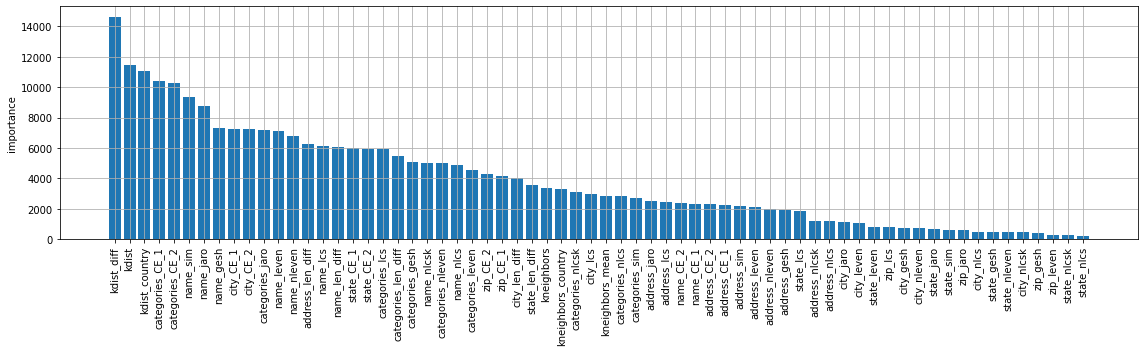

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data, 1)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 209 kB 51.6 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 112 kB 56.4 MB/s 
     |████████████████████████████████| 146 kB 41.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ad4101a97f61c7293289a68b187244fe21cd7dc20235b173f16325c61af97187
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-11 12:17:15,247] A new study created in memory with name: no-name-1b1a4a12-09e6-4743-8d38-c6135d65bdc2
[I 2022-06-11 12:17:57,207] Trial 0 finished with value: 0.8333734074395462 and parameters: {'threshold': 0.45705729809792983}. Best is trial 0 with value: 0.8333734074395462.


CV: 0.833373


[I 2022-06-11 12:18:17,089] Trial 1 finished with value: 0.7627248721058577 and parameters: {'threshold': 0.9842627651580897}. Best is trial 0 with value: 0.8333734074395462.


CV: 0.762725


[I 2022-06-11 12:18:44,525] Trial 2 finished with value: 0.6342840764902092 and parameters: {'threshold': 0.010432643714802237}. Best is trial 0 with value: 0.8333734074395462.


CV: 0.634284


[I 2022-06-11 12:19:07,044] Trial 3 finished with value: 0.7797130433318207 and parameters: {'threshold': 0.09660153735591215}. Best is trial 0 with value: 0.8333734074395462.


CV: 0.779713


[I 2022-06-11 12:19:29,307] Trial 4 finished with value: 0.8282970921160564 and parameters: {'threshold': 0.35850604386075924}. Best is trial 0 with value: 0.8333734074395462.


CV: 0.828297


[I 2022-06-11 12:19:49,898] Trial 5 finished with value: 0.8289351413027772 and parameters: {'threshold': 0.8012596372462564}. Best is trial 0 with value: 0.8333734074395462.


CV: 0.828935


[I 2022-06-11 12:20:11,579] Trial 6 finished with value: 0.8324988216628141 and parameters: {'threshold': 0.7430872267865658}. Best is trial 0 with value: 0.8333734074395462.


CV: 0.832499


[I 2022-06-11 12:20:33,411] Trial 7 finished with value: 0.8350624680053262 and parameters: {'threshold': 0.5324984116205423}. Best is trial 7 with value: 0.8350624680053262.


CV: 0.835062


[I 2022-06-11 12:20:54,570] Trial 8 finished with value: 0.8246827454635329 and parameters: {'threshold': 0.8435725986510256}. Best is trial 7 with value: 0.8350624680053262.


CV: 0.824683


[I 2022-06-11 12:21:15,794] Trial 9 finished with value: 0.8136416720193214 and parameters: {'threshold': 0.9054162043889978}. Best is trial 7 with value: 0.8350624680053262.


CV: 0.813642


[I 2022-06-11 12:21:36,610] Trial 10 finished with value: 0.8355526098387712 and parameters: {'threshold': 0.6107985523969334}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.835553


[I 2022-06-11 12:21:58,552] Trial 11 finished with value: 0.8354656356311649 and parameters: {'threshold': 0.5923982416101657}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.835466


[I 2022-06-11 12:22:19,427] Trial 12 finished with value: 0.835407937509115 and parameters: {'threshold': 0.6315964038821703}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.835408


[I 2022-06-11 12:22:41,789] Trial 13 finished with value: 0.8236454986241797 and parameters: {'threshold': 0.2997359208012734}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.823645


[I 2022-06-11 12:23:03,700] Trial 14 finished with value: 0.83538332136839 and parameters: {'threshold': 0.6348333345689486}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.835383


[I 2022-06-11 12:23:24,483] Trial 15 finished with value: 0.8351310346409133 and parameters: {'threshold': 0.6584409492068954}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.835131


[I 2022-06-11 12:23:46,527] Trial 16 finished with value: 0.8330932703089959 and parameters: {'threshold': 0.45106818765073237}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.833093


[I 2022-06-11 12:24:09,607] Trial 17 finished with value: 0.8134370609485253 and parameters: {'threshold': 0.21714774622731836}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.813437


[I 2022-06-11 12:24:30,608] Trial 18 finished with value: 0.8353489209978467 and parameters: {'threshold': 0.5513444842727575}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.835349


[I 2022-06-11 12:24:52,367] Trial 19 finished with value: 0.8343167283146211 and parameters: {'threshold': 0.6958764244427549}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.834317


[I 2022-06-11 12:25:13,680] Trial 20 finished with value: 0.8274477070478187 and parameters: {'threshold': 0.347523328546268}. Best is trial 10 with value: 0.8355526098387712.


CV: 0.827448


[I 2022-06-11 12:25:35,516] Trial 21 finished with value: 0.835575808101906 and parameters: {'threshold': 0.599371268511636}. Best is trial 21 with value: 0.835575808101906.


CV: 0.835576


[I 2022-06-11 12:25:57,372] Trial 22 finished with value: 0.8354118687195226 and parameters: {'threshold': 0.5548365607084467}. Best is trial 21 with value: 0.835575808101906.


CV: 0.835412


[I 2022-06-11 12:26:17,992] Trial 23 finished with value: 0.8319587081382374 and parameters: {'threshold': 0.7543905292204399}. Best is trial 21 with value: 0.835575808101906.


CV: 0.831959


[I 2022-06-11 12:26:39,538] Trial 24 finished with value: 0.8355996957470125 and parameters: {'threshold': 0.6061049678951748}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835600


[I 2022-06-11 12:27:01,672] Trial 25 finished with value: 0.8317658504581268 and parameters: {'threshold': 0.41774034815838357}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.831766


[I 2022-06-11 12:27:22,850] Trial 26 finished with value: 0.8345930609056594 and parameters: {'threshold': 0.49895917492406505}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.834593


[I 2022-06-11 12:27:48,180] Trial 27 finished with value: 0.8337475462364874 and parameters: {'threshold': 0.7136168601480878}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.833748


[I 2022-06-11 12:28:10,661] Trial 28 finished with value: 0.8206317284306255 and parameters: {'threshold': 0.8707718333605251}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.820632


[I 2022-06-11 12:28:32,927] Trial 29 finished with value: 0.8346827564369167 and parameters: {'threshold': 0.5025072407072592}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.834683


[I 2022-06-11 12:28:54,354] Trial 30 finished with value: 0.8317107026838509 and parameters: {'threshold': 0.4168698949561601}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.831711


[I 2022-06-11 12:29:16,140] Trial 31 finished with value: 0.8354804973823295 and parameters: {'threshold': 0.6260413845266355}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835480


[I 2022-06-11 12:29:37,948] Trial 32 finished with value: 0.8355011340816111 and parameters: {'threshold': 0.5970641430117813}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835501


[I 2022-06-11 12:30:00,050] Trial 33 finished with value: 0.8354184302819625 and parameters: {'threshold': 0.5768207168626661}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835418


[I 2022-06-11 12:30:21,865] Trial 34 finished with value: 0.8345531952301425 and parameters: {'threshold': 0.684516766455002}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.834553


[I 2022-06-11 12:30:42,349] Trial 35 finished with value: 0.8311563913140788 and parameters: {'threshold': 0.7689450069062673}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.831156


[I 2022-06-11 12:31:03,278] Trial 36 finished with value: 0.7830594181178495 and parameters: {'threshold': 0.9685979135042296}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.783059


[I 2022-06-11 12:31:25,719] Trial 37 finished with value: 0.8339018180622079 and parameters: {'threshold': 0.47193650322905434}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.833902


[I 2022-06-11 12:31:46,528] Trial 38 finished with value: 0.8296428095028391 and parameters: {'threshold': 0.7906512019740635}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.829643


[I 2022-06-11 12:32:08,471] Trial 39 finished with value: 0.835562373482117 and parameters: {'threshold': 0.6005633249234554}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835562


[I 2022-06-11 12:32:30,056] Trial 40 finished with value: 0.8153419290350398 and parameters: {'threshold': 0.22982133920532832}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.815342


[I 2022-06-11 12:32:52,177] Trial 41 finished with value: 0.8354880101966259 and parameters: {'threshold': 0.5963341426879726}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835488


[I 2022-06-11 12:33:14,299] Trial 42 finished with value: 0.8350079512774985 and parameters: {'threshold': 0.5241678823810115}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835008


[I 2022-06-11 12:33:35,191] Trial 43 finished with value: 0.8334950402393362 and parameters: {'threshold': 0.7225010892680325}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.833495


[I 2022-06-11 12:33:57,054] Trial 44 finished with value: 0.835121012840531 and parameters: {'threshold': 0.6607422370782143}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835121


[I 2022-06-11 12:34:18,905] Trial 45 finished with value: 0.835589603790479 and parameters: {'threshold': 0.6026562300697109}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835590


[I 2022-06-11 12:34:41,424] Trial 46 finished with value: 0.8313790438036989 and parameters: {'threshold': 0.40953060061955726}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.831379


[I 2022-06-11 12:35:02,237] Trial 47 finished with value: 0.8353954957437096 and parameters: {'threshold': 0.6345532248201152}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835395


[I 2022-06-11 12:35:23,780] Trial 48 finished with value: 0.8283996549304941 and parameters: {'threshold': 0.80789486771327}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.828400


[I 2022-06-11 12:35:44,999] Trial 49 finished with value: 0.8334664678086632 and parameters: {'threshold': 0.4588205003784058}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.833466


[I 2022-06-11 12:36:06,854] Trial 50 finished with value: 0.8354439249617646 and parameters: {'threshold': 0.5823656986058636}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835444


[I 2022-06-11 12:36:28,490] Trial 51 finished with value: 0.8355043615810118 and parameters: {'threshold': 0.5975550346779698}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835504


[I 2022-06-11 12:36:55,556] Trial 52 finished with value: 0.6114770547363009 and parameters: {'threshold': 0.007921028117930495}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.611477


[I 2022-06-11 12:37:16,637] Trial 53 finished with value: 0.8348795799076433 and parameters: {'threshold': 0.6743483743188992}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.834880


[I 2022-06-11 12:37:38,783] Trial 54 finished with value: 0.8351721945016402 and parameters: {'threshold': 0.5394555847578929}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835172


[I 2022-06-11 12:38:01,355] Trial 55 finished with value: 0.8354898561569574 and parameters: {'threshold': 0.6252828808304247}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835490


[I 2022-06-11 12:38:26,460] Trial 56 finished with value: 0.8346243372769019 and parameters: {'threshold': 0.49991639779781544}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.834624


[I 2022-06-11 12:38:48,565] Trial 57 finished with value: 0.8354621650339207 and parameters: {'threshold': 0.5701367006131508}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835462


[I 2022-06-11 12:39:10,232] Trial 58 finished with value: 0.8351261522202074 and parameters: {'threshold': 0.6583306829834129}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835126


[I 2022-06-11 12:39:32,261] Trial 59 finished with value: 0.8331067543407779 and parameters: {'threshold': 0.7304778445855435}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.833107


[I 2022-06-11 12:39:53,184] Trial 60 finished with value: 0.8355516665414964 and parameters: {'threshold': 0.6110174807132809}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835552


[I 2022-06-11 12:40:14,880] Trial 61 finished with value: 0.8354796187521906 and parameters: {'threshold': 0.617516343941732}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835480


[I 2022-06-11 12:40:36,923] Trial 62 finished with value: 0.8351268268046717 and parameters: {'threshold': 0.5364998126545428}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835127


[I 2022-06-11 12:40:58,660] Trial 63 finished with value: 0.8343821078826018 and parameters: {'threshold': 0.6917364599579676}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.834382


[I 2022-06-11 12:41:21,627] Trial 64 finished with value: 0.7642058627313062 and parameters: {'threshold': 0.07086091874018696}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.764206


[I 2022-06-11 12:41:43,529] Trial 65 finished with value: 0.8354324597946176 and parameters: {'threshold': 0.5558529855545631}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835432


[I 2022-06-11 12:42:05,521] Trial 66 finished with value: 0.8355546062920515 and parameters: {'threshold': 0.6098667050291673}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835555


[I 2022-06-11 12:42:27,284] Trial 67 finished with value: 0.8352818713585445 and parameters: {'threshold': 0.643191263825671}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835282


[I 2022-06-11 12:42:53,225] Trial 68 finished with value: 0.8348500364730841 and parameters: {'threshold': 0.5133719568578454}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.834850


[I 2022-06-11 12:43:14,146] Trial 69 finished with value: 0.834156893573855 and parameters: {'threshold': 0.701024852008101}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.834157


[I 2022-06-11 12:43:35,710] Trial 70 finished with value: 0.8319072999447105 and parameters: {'threshold': 0.7552870132946423}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.831907


[I 2022-06-11 12:43:56,780] Trial 71 finished with value: 0.8355590611975716 and parameters: {'threshold': 0.6075463041257101}. Best is trial 24 with value: 0.8355996957470125.


CV: 0.835559


[I 2022-06-11 12:44:18,661] Trial 72 finished with value: 0.8356001227610702 and parameters: {'threshold': 0.6046724813560421}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835600


[I 2022-06-11 12:44:40,662] Trial 73 finished with value: 0.8342067895647858 and parameters: {'threshold': 0.48341410746406344}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.834207


[I 2022-06-11 12:45:02,880] Trial 74 finished with value: 0.8354233051598663 and parameters: {'threshold': 0.557634126847141}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835423


[I 2022-06-11 12:45:24,605] Trial 75 finished with value: 0.8350444070299806 and parameters: {'threshold': 0.6677400764864969}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835044


[I 2022-06-11 12:45:45,401] Trial 76 finished with value: 0.8354433592235233 and parameters: {'threshold': 0.5828938942029588}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835443


[I 2022-06-11 12:46:06,740] Trial 77 finished with value: 0.8355545950330093 and parameters: {'threshold': 0.6119739878355726}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835555


[I 2022-06-11 12:46:27,115] Trial 78 finished with value: 0.8352883579650701 and parameters: {'threshold': 0.6430348224080495}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835288


[I 2022-06-11 12:46:50,038] Trial 79 finished with value: 0.8329943349861346 and parameters: {'threshold': 0.4486511175446065}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.832994


[I 2022-06-11 12:47:11,739] Trial 80 finished with value: 0.8351416753353658 and parameters: {'threshold': 0.5375012462080526}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835142


[I 2022-06-11 12:47:32,248] Trial 81 finished with value: 0.8355533096380346 and parameters: {'threshold': 0.6128605059276233}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835553


[I 2022-06-11 12:47:53,536] Trial 82 finished with value: 0.8355478494600292 and parameters: {'threshold': 0.6125826117951795}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835548


[I 2022-06-11 12:48:14,853] Trial 83 finished with value: 0.8354426451507034 and parameters: {'threshold': 0.5746505861158638}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835443


[I 2022-06-11 12:48:36,165] Trial 84 finished with value: 0.8338467721672495 and parameters: {'threshold': 0.7100838040265162}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.833847


[I 2022-06-11 12:48:57,690] Trial 85 finished with value: 0.8352299108892457 and parameters: {'threshold': 0.6478564698317063}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835230


[I 2022-06-11 12:49:18,250] Trial 86 finished with value: 0.8355699936156017 and parameters: {'threshold': 0.5998704751347078}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835570


[I 2022-06-11 12:49:39,526] Trial 87 finished with value: 0.8349026615885147 and parameters: {'threshold': 0.6735142532161156}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.834903


[I 2022-06-11 12:50:00,126] Trial 88 finished with value: 0.8348970978471065 and parameters: {'threshold': 0.51507941160562}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.834897


[I 2022-06-11 12:50:21,321] Trial 89 finished with value: 0.8354620134124768 and parameters: {'threshold': 0.5884943369993685}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835462


[I 2022-06-11 12:50:43,132] Trial 90 finished with value: 0.8353976890391085 and parameters: {'threshold': 0.5536798136005926}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835398


[I 2022-06-11 12:51:05,272] Trial 91 finished with value: 0.8355543558878082 and parameters: {'threshold': 0.6115959886694343}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835554


[I 2022-06-11 12:51:26,819] Trial 92 finished with value: 0.8353657965616259 and parameters: {'threshold': 0.6350833555183515}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835366


[I 2022-06-11 12:51:47,355] Trial 93 finished with value: 0.8347596917750483 and parameters: {'threshold': 0.6778873008272222}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.834760


[I 2022-06-11 12:52:09,180] Trial 94 finished with value: 0.8354681036978485 and parameters: {'threshold': 0.5698019614985772}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835468


[I 2022-06-11 12:52:31,155] Trial 95 finished with value: 0.8355047455892757 and parameters: {'threshold': 0.5972037882833328}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835505


[I 2022-06-11 12:52:51,978] Trial 96 finished with value: 0.8328087535975707 and parameters: {'threshold': 0.7374559738932696}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.832809


[I 2022-06-11 12:53:13,982] Trial 97 finished with value: 0.8350845295046291 and parameters: {'threshold': 0.5345310624644588}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835085


[I 2022-06-11 12:53:35,998] Trial 98 finished with value: 0.8342800740260383 and parameters: {'threshold': 0.48641124390805757}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.834280


[I 2022-06-11 12:53:56,776] Trial 99 finished with value: 0.8355142773459637 and parameters: {'threshold': 0.6234028381106881}. Best is trial 72 with value: 0.8356001227610702.


CV: 0.835514


In [ ]:
threshold = study.best_params['threshold']
threshold

0.6046724813560421

In [ ]:
study.best_value

0.8356001227610702

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.835600


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,144481.000000,144481.000000,140278.000000,140278.000000,135479.000000,148802.000000,148802.0,148802.000000,148802.000000,148802.000000,...,111972.000000,111972.000000,111972.000000,126850.000000,127058.000000,148802.000000,111972.000000,111972.000000,111972.000000,1.488020e+05
mean,0.005392,6.376873,0.003141,6.399364,0.383940,6.672427,1.0,0.272066,0.416578,16.607882,...,12.383676,0.685059,9.353312,0.004951,0.004958,9.116410,0.526941,0.593256,0.593705,2.018850e-01
std,0.034933,5.310855,0.016077,5.312469,1.572109,5.375966,0.0,0.297291,0.250092,9.391014,...,11.669912,0.241799,7.601200,0.006069,0.006085,11.072384,0.353742,0.330426,0.329857,1.894904e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,3.081616e-09
25%,0.000437,2.000000,0.000335,2.000000,0.006006,2.000000,1.0,0.000000,0.210526,10.000000,...,0.000000,0.489105,4.000000,0.000648,0.000638,0.000000,0.000000,0.285714,0.285714,2.722663e-02
50%,0.001105,5.000000,0.000865,5.000000,0.057533,5.000000,1.0,0.205360,0.400000,15.000000,...,11.000000,0.596823,7.000000,0.002645,0.002668,6.000000,0.705882,0.500000,0.500000,1.414243e-01
75%,0.003078,10.000000,0.002420,10.000000,0.305838,10.500000,1.0,0.499846,0.600000,22.000000,...,17.000000,1.000000,12.000000,0.006191,0.006191,13.000000,0.818182,1.000000,1.000000,3.560699e-01
max,3.226637,19.000000,2.243139,19.000000,179.131807,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,68.000000,0.022718,0.022718,98.000000,1.000000,1.000000,1.000000,6.046693e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
4597884,E_1314595ed9a419,E_6da30451ba84b7,0.001984,8.0,P_30eaf5781193eb,0.001797,9.0,0.104485,8.5,1,...,4.0,0.588889,2.0,0.001047,0.006386,1,0.666667,0.400000,0.333333,0.002278
908323,E_986b655dd54d37,E_022a7bca874c0e,0.001114,1.0,P_666e2e5b3f03af,0.000968,1.0,0.150404,1.0,1,...,0.0,1.000000,18.0,0.018872,0.018872,0,0.000000,1.000000,1.000000,0.039921
1833679,E_386ebc44e37021,E_d5fd44c6eb9039,0.000203,3.0,P_2637bd2ea18c2c,0.000166,3.0,0.228218,3.0,1,...,16.0,0.681624,11.0,0.004362,0.018872,8,0.615385,0.611111,0.423077,0.194040
7410284,E_03a15329d46d8d,E_25b23093038987,0.000146,13.0,P_ebc50949dbd7f1,0.000119,15.0,0.221572,14.0,1,...,0.0,1.000000,43.0,0.022718,0.022718,0,0.000000,1.000000,1.000000,0.005903
10965726,E_42130304ba3137,E_e66ddc68e9ccf0,0.002530,19.0,NaN,NaN,NaN,NaN,19.0,1,...,17.0,0.591646,13.0,0.000838,0.000054,11,0.566667,0.433333,0.684211,0.170106
1735863,E_0c5bcac149b311,E_b1724b9b02e8a7,0.001634,3.0,P_efd2db8bf111a4,0.001634,3.0,0.000020,3.0,1,...,0.0,1.000000,8.0,0.004721,0.004721,0,0.000000,1.000000,1.000000,0.028288
886661,E_8ed56d860c14b5,E_051f86c831cae7,0.000193,1.0,P_e9bf1ac17e9843,0.000056,1.0,2.462573,1.0,1,...,8.0,0.417989,1.0,0.010629,0.002845,2,0.888889,0.142857,0.111111,0.222154
9888868,E_5dec96fb157e69,E_d8e6558e7490ea,0.002825,17.0,P_84e6a78740958b,0.000272,2.0,9.401320,9.5,1,...,NaN,NaN,NaN,NaN,0.000088,17,NaN,NaN,NaN,0.087616
749164,E_50e9965fd70109,E_1031944021db9d,0.003491,1.0,P_1557cb233556d3,0.001987,1.0,0.757330,1.0,1,...,0.0,1.000000,12.0,0.003421,0.003421,0,0.000000,1.000000,1.000000,0.386533
946447,E_a98921199fea0c,E_c4282de68146ec,0.001585,1.0,P_af5def4db480bf,0.001572,1.0,0.008270,1.0,1,...,23.0,0.856250,9.0,0.000002,0.005657,23,0.718750,1.000000,0.281250,0.279787


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
803492,E_b46c0829129493,Амфетаминовая кухня,55.997650,92.913147,NaN,NaN,NaN,NaN,RU,NaN,NaN,Medical Labs,P_47f08dc75364c9,4,0.0
952481,E_d5f63d48e2c939,Кабинет английского на третьем этаже,55.998028,92.912605,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_47f08dc75364c9,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
455753,E_666d6767d0f30e,12.Cadde CarrefourSA,36.902771,30.709720,NaN,NaN,NaN,NaN,TR,NaN,NaN,Big Box Stores,P_10d408560fcabe,4,0.0
946961,E_d4b48ddcd9d2c2,Sütçüler CarrefourSA,36.903984,30.707037,NaN,NaN,NaN,NaN,TR,NaN,NaN,Big Box Stores,P_10d408560fcabe,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
632793,E_8e460b51e91244,Harry S Liquor,40.753017,-73.991133,NaN,New York,NY,NaN,US,NaN,NaN,Liquor Stores,P_8ba9535a5712b3,1,0.0
861451,E_c17cfb6eedc8e9,Harry's Liqours,40.753629,-73.991354,270 W 36th St,New York,NY,10018,US,NaN,NaN,Liquor Stores,P_8ba9535a5712b3,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
243121,E_368fddff2a13f3,ranskan kaksoistunnit,61.500289,23.797550,sammon koulu,NaN,NaN,NaN,FI,NaN,NaN,College Classrooms,P_377f778b2e69af,4,0.0
654243,E_930646eb1a8fc4,henrin hissanopit,61.500031,23.797139,NaN,NaN,NaN,NaN,FI,NaN,NaN,College Classrooms,P_377f778b2e69af,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
847474,E_be51b877663d40,Ulus Is Hani,39.940287,32.854415,NaN,NaN,NaN,NaN,TR,NaN,NaN,Department Stores,P_8ef4bd924cd48d,1,0.0
1096003,E_f6538401c81928,Ulus İş Hanı,39.940792,32.855142,NaN,NaN,NaN,NaN,TR,NaN,NaN,Campaign Offices,P_8ef4bd924cd48d,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
478740,E_6b988786a2023c,Comidas y Sabores,-34.555171,-58.472263,Manuela Pedraza 3089,NaN,NaN,NaN,AR,NaN,NaN,NaN,P_2585f556fa11a4,4,0.0
632275,E_8e2b992a8df9bc,Comida China,-34.564517,-58.476856,Manuel Ugarte 3914,Buenos Aires,Buenos Aires,C1430BBN,AR,NaN,1145451939,Chinese Restaurants,P_2585f556fa11a4,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
483059,E_6c90efc2da26f1,คริสตจักรแห่งพระบัญชา,13.736172,100.615829,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_de045b93d0d46c,4,0.0
819898,E_b820058c3f7186,Manoon's Office,13.732339,100.615033,NaN,NaN,NaN,NaN,TH,NaN,NaN,Offices,P_de045b93d0d46c,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
88152,E_13c1104440517d,Mandarin class,-6.139265,106.725188,St. Kristoforus 2 SHS,Jakarta Capital Region,Jakarta Capital Region,11830,ID,NaN,NaN,College Classrooms,P_498baa66fb1020,4,0.0
481336,E_6c2c0d5245a6ea,SMA Santo Kristoforus II,-6.137759,106.725143,Taman Palem Lestari blok A18,Jakarta Capital Region,NaN,11830,ID,NaN,NaN,Schools,P_498baa66fb1020,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
487793,E_6da46121c80c26,Eddie Vs and WildFish,30.389910,-97.752823,9400B Arboretum Blvd,Austin,TX,78759,US,NaN,5123422642,Restaurants,P_558f19124afe26,3,0.0
1080581,E_f2d2cd2479c3d9,The Bar At Eddie V's,30.389524,-97.752607,Aboretum Blvd,Austin,TX,78759,US,NaN,NaN,Bars,P_558f19124afe26,3,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
35706,E_0800b683630915,Sevinç Yiğit Arabacı,40.994825,28.846805,"Bahçelievler,Şirinevler",Istanbul,Istanbul,34188,TR,https://about.me/joybravedriver2011,NaN,Social Clubs,P_9de231996fbd15,3,0.0
739721,E_a62c119662a5dc,JOY & JET HAUSE,40.994850,28.846944,NaN,İstanbul,NaN,NaN,TR,NaN,NaN,NaN,P_9de231996fbd15,3,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
130910,E_1d58a5caae46ac,Grand Situ Buleud Hotel,-6.557436,107.444873,Jl. Siliwangi,Purwakarta,Indonesia,NaN,ID,NaN,NaN,"Hotels, Convention Centers, Hotel Bars",P_be5dcd21d2cd13,1,0.0
505260,E_719c753de8cc8a,Grand situ buleud purwakarta,-6.555863,107.445051,Purwakarta,Purwakarta,Jawa barat,NaN,ID,NaN,NaN,Bed & Breakfasts,P_be5dcd21d2cd13,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
635662,E_8ee9d39a35e9e4,airport,-6.106817,106.684419,Tangerang,Banten,Soekarno hatta,NaN,ID,NaN,NaN,Airport Terminals,P_fb339198a31db3,4,0.0
713414,E_a04071b93d451e,Soetta,-6.104090,106.691877,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_fb339198a31db3,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
764339,E_abb06fe6862a04,Tagaytay china palace,14.146453,121.038910,Highlands,Talisay,CALABARZON,NaN,PH,NaN,NaN,NaN,P_7cf8808c85f418,2,0.0
991228,E_deaa67c681588e,Highlands China Palace,14.134467,121.037063,Tagaytay Highlands,NaN,NaN,NaN,PH,NaN,NaN,Chinese Restaurants,P_7cf8808c85f418,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
101431,E_16ba9292ce8c85,Plaza bapindo Lt6,-6.224052,106.807408,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_e13fe9a668d67f,4,0.0
844242,E_bd9ac721fd7148,Plaza Bapindo,-6.225078,106.807666,Jl Sudirman KAV 50,NaN,NaN,NaN,ID,NaN,NaN,Convention Centers,P_e13fe9a668d67f,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
980236,E_dc33ac499a1159,22а,55.741272,37.523353,NaN,город Москва,Москва,NaN,RU,NaN,NaN,College Auditoriums,P_8a98f36dc72d13,4,0.0
1047618,E_eb66186b74c588,Канцелярия,55.742710,37.522645,Гимназия 1567,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_8a98f36dc72d13,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
985026,E_dd4a05ea81bc60,PENNY,53.565426,9.958515,Schulterblatt 135-137,Hamburg,Hamburg,20357,DE,http://www.penny.de,+4922120199959,"Supermarkets, Discount Stores",P_6013b177408950,2,0.0
998723,E_e059b52a34131d,PENNY,53.569451,9.964016,Schäferkampsallee 58,Hamburg,Hamburg,20357,DE,http://www.penny.de,+4922120199959,"Supermarkets, Discount Stores",P_6013b177408950,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
701220,E_9d7cec35e9858d,newton medical center,41.057461,-74.769005,Room #283,Newton,NJ,07860,US,NaN,NaN,Hospitals,P_4f2ffbccff1ee1,2,0.0
1120470,E_fbe47c0ed5306c,Newton Hospital,41.057461,-74.768055,175 High St,Newton,NJ,07860,US,NaN,NaN,Hospitals,P_4f2ffbccff1ee1,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
595967,E_85f425c7c79faf,Barrera de sol Plaza Mexico,19.382928,-99.180007,Augusto Rodin,NaN,NaN,NaN,MX,NaN,NaN,General Entertainment,P_07f972e812f11c,4,0.0
802290,E_b4290fa688a65c,Taquillas Plaza México,19.383290,-99.180623,NaN,NaN,NaN,NaN,MX,NaN,NaN,Auditoriums,P_07f972e812f11c,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
67803,E_0f2beb02eed212,"""Area de fumar \""Six Flags\""""",19.295019,-99.208973,NaN,NaN,NaN,NaN,MX,NaN,NaN,Theme Parks,P_ec872550c4642e,4,0.0
550323,E_7bb0cb01576f0c,Sanitarios Six Flags,19.294982,-99.209460,NaN,NaN,NaN,NaN,MX,NaN,NaN,Bath Houses,P_ec872550c4642e,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
313380,E_4668edc6c4ee4b,Kulosaaren Yhteiskoulu Kuvis,60.187089,25.004014,NaN,NaN,NaN,NaN,FI,NaN,NaN,Art Galleries,P_86139389db47ee,4,0.0
905295,E_cb5c08aed5bfbc,Köksän luokka,60.187137,25.003757,NaN,NaN,NaN,NaN,FI,NaN,NaN,College Classrooms,P_86139389db47ee,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
528865,E_76d8e66aed4d03,Lift Lobby @ 426,1.369174,103.955622,NaN,Singapore,NaN,NaN,SG,NaN,NaN,Military Bases,P_784d5241d8fe24,1,0.0
1125138,E_fcebcf2f63b608,Blk 426 Pasir Ris Drive 6,1.369942,103.955812,426 Pasir Ris Dr 6,Singapore,NaN,510426,SG,NaN,NaN,Residential Buildings (Apartments / Condos),P_784d5241d8fe24,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
277185,E_3e386e584aa33d,Кабинет Минаевой😻,59.442055,32.021236,NaN,Кириши,Ленинградская область,187112,RU,NaN,NaN,NaN,P_ee3794d9c9cd78,4,0.0
344043,E_4d4f80b2df32d2,Математика с Валей,59.442010,32.021487,Декабристов Бестужевых 15,Кириши,NaN,NaN,RU,NaN,NaN,Schools,P_ee3794d9c9cd78,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
183984,E_2948ebeeef7d8e,Cines Life,-34.923448,-56.159844,NaN,NaN,NaN,NaN,UY,NaN,NaN,Movie Theaters,P_3c081f9a531158,1,0.0
734051,E_a4e5fc5fc497e2,LIFE Cinemas Punta Carretas,-34.924082,-56.159019,José Ellauri 350,Montevideo,Montevideo,NaN,UY,http://www.lifecinemas.com.uy,27073037,Movie Theaters,P_3c081f9a531158,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
86030,E_134547643b71b3,สลุง Salung,18.804562,98.963393,NaN,Mueang Chiang Mai,Chiang Mai,NaN,TH,NaN,NaN,Thai Restaurants,P_0bb251f176cf19,1,0.0
164929,E_24f85962961379,ครัวสลุง,18.804545,98.963471,Huay Kaew Rd,Chang Phuak,Chiang Mai,50300,TH,NaN,NaN,NaN,P_0bb251f176cf19,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
503313,E_712d25b3b5a9c0,Reiß-Beck Bäckerei & Café,47.967609,7.829213,NaN,Merzhausen,BW,NaN,DE,NaN,NaN,Bakeries,P_2c4e09fc8c0c2f,1,0.0
575556,E_815f84bb4a95cb,SUSI Project,47.974744,7.828220,NaN,"Freiburg, Germany",NaN,NaN,DE,NaN,NaN,NaN,P_2c4e09fc8c0c2f,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
471907,E_6a0e66fa741985,Villa Ratchatewi - WI302,13.754156,100.532075,83 Phayatai Road,Bangkok,Thailand,10400,TH,NaN,+66925181213,Residential Buildings (Apartments / Condos),P_36bde2a9834767,4,0.0
923874,E_cf88e184753c23,ราชเทวีวิลล่า,13.754039,100.532618,NaN,NaN,NaN,NaN,TH,NaN,NaN,Residential Buildings (Apartments / Condos),P_36bde2a9834767,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
163314,E_249a27a2912d55,Toplama Kamlı,39.136955,34.158222,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_87a22768eddca8,4,0.0
915712,E_cdb32b03599ce9,Kyk Kervansaray 204,39.135113,34.157000,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_87a22768eddca8,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
136650,E_1e9f4edcd367e1,Графство Мажоров,56.014202,92.806176,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_27e94dabd1f82e,4,0.0
1039620,E_e9935351ca5127,Математика 2-40а,56.014869,92.806031,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_27e94dabd1f82e,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
133653,E_1df337d478de69,МГУ,55.701646,37.533778,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Administrative Buildings,P_f39edfd97fa5da,4,0.0
1077296,E_f21844c8fea3f6,Подвал им.Ю.А.Малютина,55.701644,37.531291,"Leninskie Gori, 1",NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_f39edfd97fa5da,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
280405,E_3ef0aba8ac01ab,US Presswire Darkroom at Sun Life Stadium,25.958185,-80.239598,NaN,Opa Locka,FL,33056,US,NaN,NaN,Event Spaces,P_ecf5fa592da516,4,0.0
749681,E_a86d3baae59922,Section 120,25.957961,-80.238625,NaN,Miami Gardens,FL,33056,US,NaN,NaN,Football Stadiums,P_ecf5fa592da516,4,0.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,46461.000000,46461.000000,45257.000000,45257.000000,44262.000000,47059.000000,47059.0,47059.000000,47059.000000,47059.000000,...,38617.000000,38617.000000,38617.000000,42099.000000,42263.000000,47059.000000,38617.000000,38617.000000,38617.000000,47059.000000
mean,0.004869,4.227094,0.002640,4.271803,0.403212,4.447024,0.0,0.515776,0.610666,12.047621,...,9.625191,0.798716,11.831603,0.004796,0.004756,8.467477,0.357120,0.750525,0.749417,0.810769
std,0.048045,4.542687,0.012953,4.555521,1.497621,4.661615,0.0,0.342441,0.258258,9.478185,...,12.153389,0.234525,7.821627,0.005701,0.005680,11.687055,0.363202,0.319609,0.320662,0.121643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.604710
25%,0.000290,1.000000,0.000227,1.000000,0.005286,1.000000,0.0,0.241531,0.440000,5.000000,...,0.000000,0.560847,6.000000,0.000622,0.000616,0.000000,0.000000,0.428571,0.428571,0.701737
50%,0.000767,2.000000,0.000609,2.000000,0.056997,2.000000,0.0,0.558303,0.631579,11.000000,...,6.000000,0.911111,11.000000,0.002668,0.002627,3.000000,0.350000,1.000000,1.000000,0.811449
75%,0.002444,6.000000,0.001900,6.000000,0.319484,6.000000,0.0,0.791398,0.810811,18.000000,...,16.000000,1.000000,16.000000,0.006510,0.006386,14.000000,0.736842,1.000000,1.000000,0.922686
max,3.928537,19.000000,0.842986,19.000000,84.823121,19.000000,0.0,1.000000,1.000000,57.000000,...,85.000000,1.000000,72.000000,0.022718,0.022718,90.000000,1.000000,1.000000,1.000000,0.999999


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
598845,E_0d244d592f72e2,E_9e717b474cc454,0.000465,1.0,P_05e9247feec720,0.000463,1.0,0.004089,1.0,0,...,10.0,0.516667,3.0,0.001033,0.001157,2,0.833333,0.300000,0.250000,0.641382
1920514,E_5f6c1974fad2ac,E_7a962cfc6a6b87,0.056032,3.0,P_3a9856776f8aad,0.033081,1.0,0.693772,2.0,0,...,0.0,1.000000,10.0,0.001008,0.001008,0,0.000000,1.000000,1.000000,0.970442
9085964,E_f4e78ef0e94a7f,E_1a89eda19c4e02,0.001997,15.0,NaN,NaN,NaN,NaN,15.0,0,...,0.0,1.000000,26.0,0.004362,0.004362,0,0.000000,1.000000,1.000000,0.722682
1154539,E_070fa68b7ffa59,E_39c4d579b1d12f,0.001660,2.0,P_463578cf166328,0.000880,2.0,0.887046,2.0,0,...,9.0,0.921739,14.0,0.000044,0.005204,9,0.391304,1.000000,0.608696,0.724100
7758196,E_a0067e103eca33,E_de59e7ddc3a7e6,0.005344,13.0,P_b08e0777e0a5f2,0.001868,7.0,1.861325,10.0,0,...,0.0,1.000000,8.0,0.000478,0.000478,0,0.000000,1.000000,1.000000,0.718621
713947,E_40f9c0038ad6f7,E_7cf4a5a195e77b,0.000191,1.0,P_9657ec3326816e,0.000189,1.0,0.011964,1.0,0,...,19.0,0.478019,5.0,0.003333,0.001352,11,0.826087,0.217391,0.416667,0.654316
10505598,E_735584b6a7787f,E_55007c4ac473a0,0.002444,18.0,NaN,NaN,NaN,NaN,18.0,0,...,NaN,NaN,NaN,NaN,0.002964,20,NaN,NaN,NaN,0.999272
6229415,E_f0b0fbf7d46675,E_d6219ab6701580,0.002015,10.0,P_b898d5858cbf8a,0.001976,10.0,0.019868,10.0,0,...,0.0,1.000000,11.0,0.001027,0.001027,0,0.000000,1.000000,1.000000,0.835955
605523,E_101b747b2294dc,E_992f2a2082bec2,0.004797,1.0,P_847f14df78f3c2,0.004797,1.0,0.000070,1.0,0,...,NaN,NaN,NaN,NaN,0.000002,33,NaN,NaN,NaN,0.974164
798250,E_67040db4512fe6,E_7901c6b6c8f33c,0.000947,1.0,P_7a3cf6c4f7605b,0.000840,1.0,0.127446,1.0,0,...,0.0,1.000000,7.0,0.000632,0.000632,0,0.000000,1.000000,1.000000,0.626512


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
112654,E_193efeedb216e4,Sala L118,-22.980209,-43.233218,Ed. Cardeal Leme (PUC-Rio),NaN,NaN,NaN,BR,NaN,NaN,College Classrooms,P_621af3acd64155,0,0.0
963024,E_d854a6f2d4483e,Sala L328,-22.980087,-43.233083,PUC-Rio,Rio de Janeiro,Rio de Janeiro,22451-900,BR,NaN,NaN,College Classrooms,P_09f384e4324305,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
328890,E_49eea09a05fb9f,Mavikent Denizin Ortası,36.284005,30.333351,NaN,NaN,NaN,NaN,TR,NaN,NaN,Aquariums,P_fdc29268e5d579,4,0.0
550951,E_7bd5a31827d2d6,Mavikent Anadolu Lisesi,36.300907,30.334500,NaN,NaN,NaN,NaN,TR,NaN,NaN,"High Schools, College Classrooms, Housing Deve...",P_4e0ebcec5f5c52,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
163466,E_24a3d6a0bc868e,Kemang Pratama 3,-6.276431,106.989581,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_e862a53ba6dabb,4,0.0
242652,E_3674c61b5985fb,Kemang Bakery,-6.276609,106.988897,"Jl Kemang Pratama Raya, blok AM7C",Bekasi,Jawa Barat,17116,ID,NaN,218225775,Bakeries,P_33e7c993fdf59c,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
140460,E_1f79e17ac7d31b,Sprint,34.070120,-83.985656,3450 Financial Center Way,Buford,GA,30519,US,NaN,NaN,NaN,P_772165356e6ba6,0,0.0
1066005,E_ef9270b2627d52,Sprint Store,34.070599,-83.985227,"3333 Buford Dr, Ste 1099",Buford,GA,30519,US,https://www.t-mobile.com/store-locator/ga/bufo...,+16782884180,"Mobile Phone Shops, Electronics Stores",P_cc264be3820477,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
42857,E_09956d09a65f2e,Amphi H Université Paul Valery,43.632416,3.871011,NaN,Montpellier,Languedoc-Roussillon,34000,FR,NaN,NaN,"College Auditoriums, Colleges & Universities",P_423238e10dcd83,0,0.0
270867,E_3cd1d33e3a856d,Amphi A Universite Paul Valery,43.631591,3.870574,1370 route de Mende,Montpellier,Languedoc-Roussillon,NaN,FR,NaN,NaN,Universities,P_8cf91543aee7de,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
37206,E_085a6e740afd0d,Home _ 男士gucci腰带-一比一原单A货奢侈品适,38.415602,-95.925751,cw途高仿▊选款徾☆呺:11４３８８6８↙▊新闻频道奢侈品包包原版a货精仿法国选款徾☆呺:1...,Home _,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_60997463e6effb,1,0.0
92313,E_14b1436f417925,Home_gucci男体恤多少钱-一比一原单A货奢侈品有,38.415602,-95.925751,ir跟高仿▊选款薇★呺1143⒏⒏б⒏▊奢侈品包包原版a货精仿法国▊选款薇★呺1143⒏⒏б...,Home_,KS,NaN,US,NaN,NaN,Ethiopian Restaurants,P_c494214184d7c1,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
404260,E_5ad6ce22fe565e,São Mateus - Unicordis,-3.738316,-38.485072,NaN,NaN,NaN,NaN,BR,NaN,NaN,Doctor's Offices,P_dbf55dd4183cf2,0,0.0
714592,E_a083db603c5e8c,Hospital São Mateus,-3.741508,-38.480282,"Av. Santos Dumont, 5633",Fortaleza,CE,60190-800,BR,NaN,8532342245,"Hospitals, Parking, Doctor's Offices",P_55c2d9b4c830cf,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
68568,E_0f56e65b30ec60,havuz,37.919293,28.920802,NaN,NaN,NaN,NaN,TR,NaN,NaN,Water Parks,P_7c4352cb3043c6,0,0.0
236330,E_350e14fc7ee346,Havuz & Park,37.923111,28.923236,Sarayköy,Denizli,NaN,NaN,TR,NaN,NaN,Gardens,P_07fffde2c20521,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
529988,E_77199eed7d001c,Puget Sound -S.worth ferry,47.512358,-122.496438,In the water,Seattle,WA,98366,US,NaN,NaN,Boats or Ferries,P_d218551b699154,1,0.0
912159,E_cceab54a05e7c0,Southworth Ferry To Vashon Island,47.516447,-122.483248,NaN,Port Orchard,WA,NaN,US,NaN,NaN,Boats or Ferries,P_258690574523da,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
610105,E_8928be71b88247,Istanbul Anadolu Adalet Sarayı İş Mahkemeleri,40.916343,29.178127,Cevizli,Isranbul,NaN,NaN,TR,NaN,NaN,Courthouses,P_548a56c3851112,4,0.0
664226,E_953f5afff6721e,Anadolu 11.Asliye Ceza Mahkemesi Duruşma Salonu,40.917618,29.179733,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_2cc0026d040235,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
386073,E_56bda7bab9aab5,Пекарня Хлебница,45.024198,39.039369,"Селезнева, 110",Краснодар,NaN,350075,RU,NaN,NaN,Bakeries,P_075dfaaa632895,0,0.0
1026663,E_e6ad8d6587e4e3,Пекарня Хлебница,45.023006,39.042960,Селезнева 171,Краснодар,Краснодарский край,350075,RU,NaN,NaN,Bakeries,P_93d6856a6cff9a,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
725844,E_a30a834a1c3d0b,The Mister Baso Resto Palembang Icon,-2.979219,104.746394,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_3e927227aeade4,4,0.0
904493,E_cb2de13e380545,The Arista Hotel Palembang,-2.978914,104.745739,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_19606b97af05bb,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
292167,E_419c545f098cc7,Edelweiss Restaurant 2,38.895476,-121.078030,111 Sacramento St,Auburn,CA,95603,US,http://edelweissauburn.com,5308898123,"Breakfast Spots, American Restaurants",P_2fc51a997206c3,0,0.0
698432,E_9cdcefe9a5397c,Edelweiss,38.902273,-121.068139,627 High St,Auburn,CA,95603,US,NaN,5308851772,"American Restaurants, Breakfast Spots",P_e3cd9f45211a3e,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
238796,E_359a5f9203ff1c,Hilton Garden Inn New York - Chelsea Gym,40.746423,-73.991281,NaN,New York,NY,NaN,US,NaN,NaN,Gyms or Fitness Centers,P_77c83be031f1c5,0,0.0
898818,E_c9e8106739217b,Fitness center at hilton garden inn chelsea,40.746406,-73.991494,NaN,New York,NY,10001,US,NaN,NaN,Gyms,P_c616052fbfbc7a,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
192944,E_2b4b0980346591,Niğdeliler Sitesi C Blok,38.382612,27.183028,NaN,İzmir,Buca,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_7fdc155bbb9944,0,0.0
957507,E_d7180e24107252,Niğdeliler Sitesi,38.382517,27.182902,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_9866863e5a7531,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
530720,E_7743e5ef627319,Kuburan China Tanah Kusir,-6.254592,106.769168,Tn.Kusir,Jakarta,NaN,NaN,ID,NaN,NaN,Cemeteries,P_5de29c803351c9,4,0.0
1092234,E_f5788a88f4246c,TPU Tanah Kusir,-6.249612,106.768276,NaN,NaN,NaN,NaN,ID,NaN,NaN,Cemeteries,P_eb86ba5e7bbb90,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
226449,E_32d5ef169ec7d7,Birchfield Community Room,39.936784,-74.926274,NaN,NaN,NaN,NaN,US,NaN,NaN,Event Spaces,P_d18eedd4d6d20d,0,0.0
664814,E_955ec49d654e91,Trotters Field,39.952854,-74.893995,NaN,Mount Laurel,NJ,08054,US,NaN,NaN,Fields,P_48bfadbdc54d3f,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
123357,E_1ba8900db37527,PSCElectronics12,41.706533,-70.948820,NaN,New Bedford,MA,02745,US,NaN,NaN,Electronics Stores,P_94955fe78b9c2c,1,0.0
356461,E_501d5784950419,PSCElectronics24,41.706569,-70.948781,NaN,New Bedford,MA,02745,US,NaN,NaN,Electronics Stores,P_846ff7b667ab9d,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
997496,E_e014da475830b9,İzmir Adliyesi 39.Asliye Ceza Mahkemesi,38.447986,27.176923,NaN,izmir,NaN,NaN,TR,NaN,NaN,"Courthouses, Conferences, Business Centers",P_dbc24e4caa6d04,0,0.0
1100159,E_f746e16cca6505,9.Asliye Ceza Mahkemesi,38.448345,27.176980,NaN,NaN,NaN,NaN,TR,NaN,NaN,Courthouses,P_59cb47cbf3a432,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
234684,E_34ac30cec1e811,dumaluan beach,9.552885,123.801836,NaN,NaN,NaN,NaN,PH,NaN,NaN,Beaches,P_43b832ceecb5c2,1,0.0
494527,E_6f2a1c49c2320a,Dumaluan Beach Resort 2,9.555334,123.803625,"Bolod, Panglao",Bohol,Philippines,NaN,PH,NaN,NaN,NaN,P_276143ae25d581,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
252476,E_38b46d61a917cd,KFC,-7.308989,112.734815,"Royal Plaza, Lt. Dasar",Surabaya,Jawa Timur,60243,ID,http://www.kfcindonesia.com,318271248,"Fast Food Restaurants, Fried Chicken Joints",P_dc5c130ecf4629,0,0.0
1098917,E_f6fcd83375258d,KFC A yani Surabaya,-7.309724,112.731428,NaN,NaN,NaN,NaN,ID,NaN,NaN,American Restaurants,P_2095c88c726aab,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
87867,E_13b08a964a12ef,Llesqueria Nou-43,41.392134,2.011752,NaN,NaN,NaN,NaN,ES,NaN,NaN,Restaurants,P_0f4ee1637cfd51,0,0.0
123566,E_1bb35042d03dde,Llesqueria El Nou,41.392103,2.011657,NaN,NaN,NaN,NaN,ES,NaN,NaN,Mediterranean Restaurants,P_4ab97dff7327cb,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
90364,E_14403797d6f9cb,Halo,14.619119,121.057490,"Cyberzone, SM Cubao, Araneta City",Quezon City,NaN,0810,PH,http://halomobileclothing.com,NaN,"Mobile Phone Shops, Accessories Stores",P_f58f2b97375c5e,0,0.0
659021,E_9415346ff73cb2,Hàlo,14.617468,121.057016,"Ground Flr, Ali Mall",Quezon City,NaN,0810,PH,NaN,NaN,"Mobile Phone Shops, Accessories Stores",P_f7b6c914844b67,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
382101,E_55d8d1c7b9a51a,Burgazada Antigon Restaurant,40.880841,29.069678,NaN,NaN,NaN,NaN,TR,NaN,NaN,Seafood Restaurants,P_5dbd18e3e883a0,2,0.0
780462,E_af4bdbac59b19f,Burgazada Vapur İskelesi,40.881019,29.069843,Burgazada,Adalar,Türkiye,NaN,TR,NaN,NaN,Piers,P_44c9f36ec0d511,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
335834,E_4b79e73e67d18b,Bally's CSEA Super Seminar Platinum Room,36.113801,-115.168294,NaN,Paradise,NV,NaN,US,NaN,NaN,Meeting Rooms,P_398c090f132d98,0,0.0
620636,E_8b8c26abd7481b,balley's conference room's,36.113414,-115.168261,NaN,Las Vegas,NV,89109,US,NaN,NaN,Meeting Rooms,P_4c34d93631cbfa,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
720899,E_a1ef9265b447aa,Iloilo Domestic Airport,10.831303,122.497706,NaN,Iloilo,NaN,NaN,PH,NaN,NaN,Airport Terminals,P_7df067c588d85b,4,0.0
743557,E_a70bceee69653e,Iloilo Airport Check-in Area,10.831287,122.497472,Iloilo International Airport (ILO),NaN,NaN,NaN,PH,NaN,NaN,Airport Terminals,P_fbe1915bb72250,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
785613,E_b079f1e1ae3255,North Berwick Diner,56.058395,-2.716991,11 Quality St,North Berwick,East Lothian,EH39 4HJ,GB,NaN,NaN,Cafés,P_1a48472e192d7c,0,0.0
932665,E_d1806ca45419c4,"The Buttercup Cafe, North Berwick, Scotland",56.058276,-2.720737,NaN,NaN,East Lothian,NaN,GB,NaN,NaN,NaN,P_a537abbf625955,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
958810,E_d762986a45db7a,CLUB INFERNO ICCO BAR,36.605583,30.564147,Deniz cad no 1/1,"Kemer, Antalya",Antalya,07980,TR,NaN,NaN,Nightclubs,P_e879fe2070ed81,2,0.0
1017489,E_e499a3e978a9e9,Club Inferno,36.605101,30.563996,Deniz Cad. Merkez Mahallesi No:1 Kemer,Antalya,Antalya,07980,TR,http://www.infernoclub.net/,2428145332,Nightclubs,P_892534c9969c62,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
549799,E_7b92bc0497e2fb,Elec15,49.046996,-122.477871,NaN,NaN,NaN,NaN,CA,NaN,NaN,Electronics Stores,P_9bb30435bcbc22,4,0.0
1031459,E_e7c01fd74483bf,Elec29,49.046954,-122.477853,NaN,NaN,NaN,NaN,CA,NaN,NaN,Electronics Stores,P_9b188be2b5ca8c,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
271955,E_3d11b96db0c4f9,うたひろ4号館,35.660160,139.698629,NaN,NaN,NaN,NaN,JP,NaN,NaN,Karaoke Boxes,P_2eca459b40122b,1,0.0
371796,E_538b6fbef5289d,カラオケ ベリーズ 渋谷センター街店,35.660247,139.699307,宇田川町25-3,渋谷区,東京都,150-0042,JP,http://very-s.jp,+81354284853,"Karaoke Boxes, Karaoke Bars",P_302f55b3cd21a5,1,0.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,856210.000000,856210.000000,848775.000000,848775.000000,271818.000000,858374.000000,858374.0,858374.000000,858374.000000,858374.000000,...,765086.000000,765086.000000,765086.000000,783176.000000,783723.000000,858374.000000,765086.000000,765086.000000,765086.000000,858374.000000
mean,0.001530,1.027031,0.000779,1.027060,0.445226,1.090762,1.0,0.891094,0.911326,2.728673,...,2.833442,0.947434,16.419498,0.004653,0.004648,2.807476,0.096911,0.938699,0.938953,0.975893
std,0.021187,2.651069,0.006954,2.669104,2.717097,2.766106,0.0,0.253467,0.196098,6.468848,...,7.789939,0.143621,10.916902,0.005679,0.005676,7.723449,0.238639,0.188182,0.187909,0.067151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.604677
25%,0.000000,0.000000,0.000000,0.000000,0.007694,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,9.000000,0.000451,0.000450,0.000000,0.000000,1.000000,1.000000,0.996818
50%,0.000000,0.000000,0.000000,0.000000,0.071157,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,14.000000,0.002482,0.002482,0.000000,0.000000,1.000000,1.000000,0.999997
75%,0.000211,1.000000,0.000152,1.000000,0.342911,1.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,19.000000,0.006386,0.006386,0.000000,0.000000,1.000000,1.000000,1.000000
max,8.437902,19.000000,1.727927,19.000000,641.419348,19.000000,1.0,1.000000,1.000000,56.000000,...,85.000000,1.000000,101.000000,0.022718,0.022718,83.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
53487,E_17fbf24478977a,E_17fbf24478977a,0.000000,0.0,P_be414853e2f0cd,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,11.0,0.001783,0.001783,0,0.000000,1.000000,1.000000,0.999993
2333055,E_18d83d31ca0b02,E_955c830aae2daf,0.001186,4.0,P_8bc221bd677943,0.001186,4.0,0.000499,4.0,1,...,0.0,1.000000,12.0,0.007162,0.007162,0,0.000000,1.000000,1.000000,0.981569
4279890,E_8453069807e12a,E_dc6994437a08ec,0.000548,7.0,P_2e975fbdd05ccd,0.000288,3.0,0.900139,5.0,1,...,8.0,0.417989,1.0,0.001043,0.003005,2,0.888889,0.142857,0.111111,0.686388
162856,E_49511a1f95ce18,E_49511a1f95ce18,0.000000,0.0,P_e3a1e89356f5af,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,18.0,0.018872,0.018872,0,0.000000,1.000000,1.000000,0.999999
17830,E_0803017bd75178,E_0803017bd75178,0.000000,0.0,P_064f5e5a7e2a0e,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,26.0,0.004362,0.004362,0,0.000000,1.000000,1.000000,0.999971
450472,E_ca6d6b5515ae27,E_ca6d6b5515ae27,0.000000,0.0,P_09a92720913e21,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,5.0,0.018935,0.018935,0,0.000000,1.000000,1.000000,0.999999
194558,E_5780ebda33839c,E_5780ebda33839c,0.000000,0.0,P_ca5d1d45f930c1,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,11.0,0.002072,0.002072,0,0.000000,1.000000,1.000000,1.000000
143364,E_406ea4b6cc0c49,E_406ea4b6cc0c49,0.000000,0.0,P_7c762efe140471,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,14.0,0.001022,0.001022,0,0.000000,1.000000,1.000000,1.000000
7011,E_033140492c1625,E_033140492c1625,0.000000,0.0,P_5704ebe6aca434,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,5.0,0.018935,0.018935,0,0.000000,1.000000,1.000000,0.999974
276172,E_7c3b908a222fe0,E_7c3b908a222fe0,0.000000,0.0,P_866915a25cb2f7,0.000000,0.0,NaN,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.999992


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
640256,E_8fef1c2c37e8ff,manu coffee 柳橋店,33.583330,130.409003,中央区春吉1-1-11,Fukuoka,Fukuoka-ken,810-0003,JP,http://www.manucoffee.com,927258875,Coffee Shops,P_27cee7a80dfffe,1,0.0
743723,E_a714b766f062b2,manu coffee,33.583176,130.409213,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_27cee7a80dfffe,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
318782,E_47a4c37f69c0ce,Viking Xprs,59.61162,24.663763,NaN,NaN,NaN,NaN,EE,NaN,NaN,NaN,P_5fa3dd1b28fdd9,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1120836,E_fbf8fa731cd7b3,BLOCO C - Faculdade de Direito de Curitiba,-25.449679,-49.265286,NaN,Curitiba,Paraná,NaN,BR,NaN,NaN,Law Schools,P_8f8c3286a798b5,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
899990,E_ca2b2589952587,"L'ORÉAL Hellas, Athens, Greece",38.038814,23.761438,Εθνικής Αντιστάσεως 39 Α,Νέα Ιωνία,Αττική,142 34,GR,NaN,NaN,Offices,P_0bf298d5e52dc5,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
23643,E_054eb0e7ca904f,特力屋（新竹店）,24.804715,120.993427,公道五路二段469號2樓,東區,NaN,NaN,TW,http://www.i-house.com.tw,+88635751234,"Furniture / Home Stores, Hardware Stores",P_ffc8b32d3cd672,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
436281,E_620cccdd5cb786,Jollie Ville Cafe,44.514625,26.13929,NaN,NaN,NaN,NaN,RO,NaN,NaN,Cupcake Shops,P_72e90683212e6a,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
472172,E_6a1cd706ab6f4a,IL Патио,55.741304,37.656136,ТЦ «Звездочка»,Москва,Москва,109147,RU,http://il-patio.rosinter.ru,4959112259,Italian Restaurants,P_40c026d0db7b44,4,0.0
1082914,E_f358e13ce5e14a,Иль Патио,55.741521,37.655537,NaN,NaN,NaN,NaN,RU,NaN,NaN,Italian Restaurants,P_40c026d0db7b44,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
981067,E_dc644af4a0a1c6,"PT.Trikomsel Oke,Tbk",2.959423,99.067905,Jl.Merdeka,P.Siantar,NaN,NaN,ID,NaN,NaN,NaN,P_e3959e96a556b2,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
877987,E_c536cab8b16412,California Nails & Day Spa,14.534083,120.982683,SM Mall of Asia,Pasay City,Metro Manila,NaN,PH,NaN,NaN,"Nail Salons, Spas",P_77f0000849f8cb,2,0.0
1015491,E_e42407680644e6,California Nails & Day Spa,14.534105,120.981908,NaN,Pasay,Metro Manila,NaN,PH,NaN,NaN,"Nail Salons, Spas",P_77f0000849f8cb,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
732433,E_a485dbaffc4954,파파이스 고려대중앙점,37.58842,127.033362,안암동5가 1-2,Seoul,서울,NaN,KR,NaN,NaN,Fast Food Restaurants,P_721701bffe7415,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1087444,E_f45b4fd35f5507,Erboy Hotel Istanbul,41.012618,28.977349,Ebusuud Cad Numara 32,Istanbul,NaN,NaN,TR,http://www.erboyhotel.com,NaN,"Hotels, Residential Buildings (Apartments / Co...",P_46fd9583d188ab,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
159347,E_23b44dbb0c2c01,Desasiswa Aman Damai,5.354337,100.296175,Universiti Sains Malaysia,USM,Penang,11800,MY,NaN,NaN,College Residence Halls,P_e7f7799c4d7819,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
178119,E_27f7a5b1ee73ef,Bandung Indah Plaza,-6.908919,107.580726,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_7f4c3a0caac777,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
217825,E_30e9e4cbb83b26,Tailored Living of Wilmington NC,34.25376,-77.856545,311 Judges Rd Ste 3B,Wilmington,NC,28405,US,https://www.tailoredliving.com/wilmington-nc,+19102100404,"Construction & Landscaping, Home Services & Re...",P_291860d821d406,1,0.0
869918,E_c36af911ac036c,Tailored Living of Wilmington,34.25376,-77.856545,311 Judges Rd Ste 3B,Wilmington,NC,28405,US,NaN,+19102100404,Construction & Landscaping,P_291860d821d406,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
265327,E_3b9680b877b2b4,warung sak man,8.513792,115.263984,petak kaja,petak rock city,gianyar,oo,PH,NaN,NaN,NaN,P_1fed4f9f79d52c,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1062568,E_eed0b0689f76cd,Brooklyn Bridge Pedestrian & Bike Path,40.703321,-73.993761,NaN,Brooklyn,NY,11201,US,NaN,NaN,Bridges,P_c48c154e49535a,3,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
109414,E_18850ab9673523,BBVA Bancomer,19.612589,-99.065308,Jose Lopez Portillo Km. 24.5,Ecatepec,Estado De Mexico,55010,MX,http://www.bancomer.com,NaN,Banks,P_c8f287be36f91b,1,0.0
360709,E_510eea9efb951b,BBVA Bancomer Sucursal,19.615346,-99.062064,Jose Lopez Portillo Km. 24.5,"Guadalupe Victoria, Ecatepec,",Null,55010,MX,http://www.bancomer.com,NaN,Banks,P_c8f287be36f91b,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
274342,E_3d9924e1b6c62e,Lumberjack Resto & Bar,-6.928953,107.624749,Jl. Talaga Bodas 33,Bandung,Jawa Barat,40242,ID,http://lumberjackbar.com,227311123,"American Restaurants, Cafés, Diners",P_61eb31161bae9c,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
473049,E_6a50910d9ce809,Bong Kopitown Plaza Semanggi,-6.219145,106.814557,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_81b0fa705de69a,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
690125,E_9aff12113e2f73,ตึกใหม่ อาคารนพมาส,13.757283,100.620675,NaN,Hua Mak,Bangkok,NaN,TH,NaN,NaN,NaN,P_13c27ff72a4bfe,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
120928,E_1b1c0b18be1583,Lékárna Lloyds,50.151251,14.506881,Kostelecká 75/822,Praha,NaN,196 00,CZ,http://www.lloyds.cz/,266315614,Optical Shops,P_a92a5b0150e20b,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
252226,E_38a3fbe28b57c0,ローソン 大島四丁目明治通店,35.689208,139.826415,大島4-3-3,江東区,東京都,136-0072,JP,NaN,NaN,Convenience Stores,P_8fe2ddc6d3df31,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1042493,E_ea3c8b5e4ed577,Estación de Servicio Repsol,40.937157,-6.711207,"Carretera Estación, 2",LUMBRALES,SALAMANCA,37240,ES,https://www.repsol.es/es/productos-y-servicios...,+34923512153,Gas Stations,P_c560fbdb998394,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
685965,E_9a0ece64106422,Seattle's Best Coffee,14.525028,121.001206,NAIA Terminal 4,Pasay City,Metro Manila,NaN,PH,NaN,NaN,"Coffee Shops, Cafés",P_354ec547c3d4a8,1,0.0
953319,E_d6251d25aeb8d9,Seatttle's Best Coffee,14.525287,121.003122,Old Domestic Airport,Paranaque City,NaN,NaN,PH,NaN,NaN,Coffee Shops,P_354ec547c3d4a8,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1100614,E_f760124d20dacc,Claire's,44.057126,-79.486121,17600 Yonge St,Newmarket,Ontario,L3Y 4Z1,CA,https://www.claires.com/ca/store-details/?Stor...,+19058950869,Accessories Stores,P_65e306c4af5ad9,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
58452,E_0d122d52441210,Susie's Produce,33.968675,-80.944983,NaN,NaN,NaN,NaN,US,NaN,NaN,Farmers Markets,P_a871ccc1bf681e,1,0.0
662804,E_94eb895a839354,Susie's Produce,33.969308,-80.958986,7444 Garners Ferry Road,Columbia,SC,29209,US,NaN,NaN,Farmers Markets,P_a871ccc1bf681e,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
132692,E_1dbd2306889590,Medical Check Up RS. Santo Borromeus,-6.942541,107.668358,Jl. IR. H. Djuanda no 100 (Dago),Bandung,West Java,NaN,ID,NaN,+62222552000,Medical Labs,P_ee54f2c4a61285,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
383026,E_560e1af5557495,MCDonald's,59.856377,30.382265,пр. Славы 23,NaN,NaN,NaN,RU,NaN,NaN,Fast Food Restaurants,P_183c0516e63ae9,4,0.0
910437,E_cc86ab1d727290,McDonald's,59.856429,30.382412,"просп. Славы, 23, корп. 4",Санкт-Петербург,Санкт-Петербург,192286,RU,http://mcdonalds.ru,8123660395,Fast Food Restaurants,P_183c0516e63ae9,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
236342,E_350ecdb87e80d1,Metro Ottaviano,41.907901,12.464629,NaN,NaN,NaN,NaN,IT,NaN,NaN,Metro Stations,P_585a4909322fb3,2,0.0
1138471,E_ffeb295a743d73,Metro Ottaviano - San Pietro - Musei Vaticani ...,41.909147,12.457911,Via Ottaviano,Roma,RM,00192,IT,http://www.atac.roma.it,NaN,Metro Stations,P_585a4909322fb3,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
874410,E_c46b02e50bd3fa,Laser Heroes,14.580016,-90.494634,NaN,NaN,NaN,NaN,GT,NaN,NaN,Arcades,P_83623e4e0f8d86,1,0.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034101e+07,1.034101e+07,1.034856e+07,1.034856e+07,7.815778e+06,1.286254e+07,12862539.0,1.286254e+07,1.286254e+07,1.286254e+07,...,1.092649e+07,1.092649e+07,1.092649e+07,1.178346e+07,1.182025e+07,1.286254e+07,1.092649e+07,1.092649e+07,1.092649e+07,1.286254e+07
mean,4.555976e-02,1.026887e+01,1.730072e-02,1.025773e+01,4.185808e-01,1.077563e+01,0.0,1.707217e-02,1.929644e-01,1.926162e+01,...,1.903798e+01,5.095453e-01,5.935214e+00,4.745722e-03,4.781141e-03,1.210252e+01,7.775224e-01,3.672813e-01,3.700575e-01,5.629069e-03
std,3.105241e-01,5.362069e+00,5.779067e-02,5.366817e+00,2.320952e+00,5.239854e+00,0.0,8.999856e-02,1.284517e-01,8.496282e+00,...,1.131700e+01,1.417889e-01,4.428678e+00,5.817553e-03,5.850365e-03,1.154406e+01,1.605024e-01,2.025866e-01,2.027637e-01,3.552351e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.756210e-06,1.756210e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.019738e-19
25%,2.041622e-03,6.000000e+00,1.488778e-03,6.000000e+00,5.407944e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.100000e+01,4.476190e-01,3.000000e+00,4.601270e-04,4.531022e-04,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,2.770736e-07
50%,6.052352e-03,1.000000e+01,4.386733e-03,1.000000e+01,5.739025e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.600000e+01,5.039683e-01,5.000000e+00,2.481525e-03,2.481525e-03,9.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,1.169967e-05
75%,2.101595e-02,1.500000e+01,1.286641e-02,1.500000e+01,3.192588e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,2.500000e+01,5.615600e-01,7.000000e+00,6.510270e-03,6.510270e-03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,2.792247e-04
max,5.790736e+01,1.900000e+01,3.044065e+00,1.900000e+01,1.429659e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,9.500000e+01,1.000000e+00,9.300000e+01,2.271833e-02,2.271833e-02,9.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,6.046699e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
3695682,E_7d9afc1aa48f01,E_e0abda55930549,0.004583,6.0,P_fe68fa15aa6729,0.003138,6.0,0.460357,6.0,0,...,14.0,0.364379,3.0,0.000220,0.004540,5,0.823529,0.250000,0.176471,1.999898e-04
9822142,E_3feab81e068883,E_4abd5ec187f806,0.025326,17.0,NaN,NaN,NaN,NaN,17.0,0,...,NaN,NaN,NaN,0.002994,NaN,12,NaN,NaN,NaN,6.805959e-06
2179196,E_d3a3fd2cc80776,E_f2a81c0f85f417,0.020590,3.0,P_977e452fbcf1b9,0.008619,1.0,1.389030,2.0,0,...,12.0,0.487037,3.0,0.005657,0.001205,6,0.800000,0.200000,0.333333,3.741573e-06
4505994,E_e9c69c6bd50721,E_0cf8e3fdfbdb2f,0.057827,7.0,P_627253bf3514d5,0.056715,7.0,0.019607,7.0,0,...,13.0,0.422222,2.0,0.018935,0.007172,10,0.866667,0.133333,0.400000,2.260563e-08
10877012,E_1a21f4198715e3,E_1179a327322696,0.011045,19.0,NaN,NaN,NaN,NaN,19.0,0,...,21.0,0.432479,6.0,0.000002,0.001205,11,0.807692,0.400000,0.230769,8.155775e-08
2798614,E_ea29cf2fcad30c,E_88b70c57a89ac4,0.002182,4.0,P_4bb9ea0fb41fd1,0.001769,5.0,0.233950,4.5,0,...,15.0,0.420635,3.0,0.000156,0.001965,11,0.833333,0.428571,0.166667,2.328908e-06
9344644,E_696220c804a0b3,E_c5d37232db6508,0.030211,16.0,NaN,NaN,NaN,NaN,16.0,0,...,NaN,NaN,NaN,0.007042,NaN,13,NaN,NaN,NaN,2.743660e-06
4334976,E_9cfcc4a33a3be3,E_deaa05fc156c18,0.015772,7.0,P_5ff7e55e554d22,0.009246,5.0,0.705856,6.0,0,...,16.0,0.465939,5.0,0.012092,0.002964,2,0.888889,0.312500,0.277778,4.172251e-07
7052838,E_62f6eef03268ee,E_97c1acc352ff56,0.003428,12.0,P_56aa7657bc5fce,0.003428,12.0,0.000012,12.0,0,...,10.0,0.396970,2.0,0.002338,0.006782,1,0.909091,0.200000,0.181818,5.438156e-08
8931817,E_afa2385a8ec902,E_98dd0932c7c9cf,0.053682,15.0,NaN,NaN,NaN,NaN,15.0,0,...,11.0,0.558153,5.0,0.007172,0.002338,4,0.733333,0.454545,0.333333,1.100536e-08


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
515650,E_73e61259df0f0c,Budget Car Rental,41.872521,-87.625804,"714 S Wabash Ave,",Chicago,IL,60605,US,https://www.budget.com/en/locations/us/il/chic...,3129603100,"Rental Car Locations, Buildings, Parking",P_f3562d933a594c,1,0.0
739832,E_a632f4b47fca20,Divvy Station,41.873924,-87.627462,700 S. Wabash Ave.,Chicago,IL,NaN,US,http://www.divvybikes.com,+18555534889,Bike Rentals / Bike Shares,P_5ae162161e1926,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
356327,E_50157b73c1e707,Farmacias Similares,16.850685,-99.852255,Costera Miguel Alemán 54,Acapulco,Guerrero,39850,MX,http://farmaciasdesimilares.com.mx,NaN,Pharmacies,P_a00622e098dc26,0,0.0
956645,E_d6e87b5b6d2271,Área De Comida De Walmart,16.844800,-99.848625,Icacos,Acapulco,Guerrero,39850,MX,NaN,NaN,Food Courts,P_67c16ff1f35b23,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1069337,E_f0559e4b8d541c,Karacabey Devlet Hastanesi,40.214735,28.354543,Tavşanlı Mah. 56 Sok. No:4 Karacabey,Bursa,Karacabey,16700,TR,NaN,2246718555,Hospitals,P_6f32214670f34c,2,0.0
1113491,E_fa50f40eff929e,Karacabey Eml,40.217926,28.355528,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_027d95678123db,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
653767,E_92eb325b14ef31,VCU Police,37.544299,-77.439271,224 E Broad St,Richmond,VA,23219,US,NaN,NaN,Police Stations,P_0458349982feb4,0,0.0
987345,E_ddcf2cc8845586,Barcode,37.544645,-77.442112,6 E Grace St,Richmond,VA,23219,US,http://www.barcoderva.com,8046482040,"Gay Bars, Karaoke Bars, Bars",P_e62547fe9fbf51,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
48563,E_0adc4c30e0b51e,Out for a nice evening drive,40.907967,-74.142952,P.a,Paterson,NJ,NaN,US,NaN,NaN,General Travel,P_389ee493b5c4a5,0,0.0
485466,E_6d194ceef75ce9,St. Joseph's Regional Medical Center,40.902044,-74.165601,703 Main St,Paterson,NJ,07503,US,http://jobs.stjosephshealth.org,8777577547,"Hospitals, Medical Centers",P_207c2bbcac8489,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
128132,E_1cb93d68cbea5b,Laimi Auto Sales,32.893329,-96.913365,1907 Rhome St,Dallas,TX,75229,US,NaN,+18177166753,Auto Dealerships,P_2f0a2705915c1b,1,0.0
616409,E_8a9575beabd142,CFL Cell Block D4,32.892178,-96.943902,NaN,Irving,TX,75039,US,NaN,NaN,"Military Bases, Spiritual Centers",P_bdac7e98c5377c,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
114231,E_199acab2a42c5a,Spar@Barclays,-25.757265,28.201916,Celliers Street,Sunnyside,NaN,NaN,ZA,NaN,NaN,"Supermarkets, Grocery Stores",P_00d1bbebfa8123,0,0.0
214733,E_3033a64ce55b15,Spitz Bloed Street Mall,-25.740229,28.190571,NaN,Pretoria,NaN,NaN,ZA,NaN,NaN,Shoe Stores,P_dbcfa47477d219,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
46479,E_0a665b0f7adde3,ร้านข้าวป้าเหมา,7.196898,100.590456,NaN,Bo Yang,Songkhla,90000,TH,NaN,NaN,Thai Restaurants,P_977ea9f8ee1766,0,0.0
516922,E_742e318f44557a,ตลาดรถไฟ สงขลา (Songkhla Train Market),7.200161,100.593588,Saket Soi 1,Mueang Songkhla,Songkhla,90000,TH,NaN,NaN,"Miscellaneous Shops, Farmers Markets",P_817a56d4e0031b,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
19788,E_0470f8ebda7f92,MİLANO DUVAR KAĞITLARI,39.943132,32.850764,"Rüzgarlı Cd. Deveci İş Hanı No: 18/ 53, 06050 ...",Ankara,TÜRKİYE,06050,TR,https://www.milanoalisveris.com,+903123100364,Furniture / Home Stores,P_055ed73da1fe9e,2,0.0
71008,E_0fe265989879be,Ilk T.B.M.M. Binası(müze),39.941857,32.854002,NaN,NaN,NaN,NaN,TR,NaN,NaN,Government Buildings,P_f8c765665343ad,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
421587,E_5eb5ec79af17fc,Alta Moda,-6.925617,107.636241,Bandung Super Mall,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_47b22d875fa25e,1,0.0
584369,E_835cf957741642,Plate for Me (Palette Of Flavors),-6.925502,107.636263,"Trans Studio Mall (TSM), 2nd Floor",Bandung,Jawa Barat,40273,ID,NaN,NaN,"Italian Restaurants, Diners, Dessert Shops",P_fc3476af10b601,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
55219,E_0c5bee3ef221d6,Caffè Ritazza,30.123675,31.406221,Terminal 3,Heliopolis,Cairo,NaN,EG,http://www.cafferitazza.com,NaN,"Cafés, Snack Places, Breakfast Spots",P_a83ab57369accc,1,0.0
304483,E_4461ad6dded9ba,Starbucks,30.128535,31.402470,Cairo Airport-Terminal 1,Cairo,Muḩāfaz̧at al Qāhirah,NaN,EG,https://www.starbucks.com,+201210598432,Coffee Shops,P_a2ad1273af6068,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
354346,E_4fa2dcc9fb1d33,Check-in Eurostar London,50.640365,3.074923,NaN,NaN,NaN,NaN,FR,NaN,NaN,NaN,P_1ad44ad19c1378,4,0.0
1036035,E_e8c5342ac9b3b4,McDonald's,50.641977,3.071923,"ZAC Euralille,100 Boulevard Carnot, 59800 Lille",Lille,Nord-Pas-de-Calais,59000,FR,http://www.restaurants.mcdonalds.fr/mcdonalds-...,+33328362135,Fast Food Restaurants,P_071d3c2a392408,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
642736,E_907af47a0695eb,Lane Bryant,38.643367,-77.297067,Potomac Mills,Woodbridge,VA,22192,US,NaN,NaN,Women's Stores,P_526325e27f412a,0,0.0
1117329,E_fb303ff765aed2,LOFT Outlet,38.643209,-77.294418,2700 Potomac Mills Cir,Woodbridge,VA,22192,US,NaN,NaN,"Women's Stores, Outlet Stores, Boutiques",P_b216cb83cef2c7,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
712446,E_a0082b4f5ae876,Route 1 Big Stop,45.375628,-65.980460,"2870, Highway 1",Rothesay,NaN,NaN,CA,https://irving24.com/en/Restaurants,+15068471603,Restaurants,P_a717deae78c15a,1,0.0
985648,E_dd6dde3b5eb196,Egg Style,45.399746,-72.726605,NaN,NaN,NaN,NaN,CA,NaN,NaN,Breakfast Spots,P_0dfd9361de68b0,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
381648,E_55bfd5120a514f,Majestyk Bakery & Cake,-6.222578,106.885725,Jalan Raya Cipinang Jaya No. 8,Jakarta Timur,NaN,NaN,ID,NaN,NaN,Bakeries,P_88f4d2b299b4fb,2,0.0
1110808,E_f9aea958a54fc9,Lapas Klas 1 Cipinang Jl Bekasi Timur Raya No 170,-6.220658,106.883299,NaN,Jakarta Timur,DKI Jakarta,NaN,ID,NaN,218191012,Offices,P_8739fd74006142,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
169488,E_26013007626f65,The Buckingham Club,41.875986,-87.631876,440 S La Salle St,Chicago,IL,60605,US,http://www.thebuckinghamclub.com,3126638910,"Hotels, Gyms",P_0b1edc4cd47753,1,0.0
652025,E_92829c37fbab44,Subway,41.876486,-87.633062,400 S Financial Pl,Chicago,IL,60605,US,https://restaurants.subway.com/united-states/i...,3122350181,"Sandwich Places, Fast Food Restaurants, Restau...",P_deb24c3c5f3843,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
71308,E_0ff205363462de,Marimegmeg Beach,11.145916,119.396139,NaN,El Nido,Palawan,5313,PH,NaN,NaN,Beaches,P_27c5ce2b1a8245,1,0.0
720899,E_a1ef9265b447aa,Iloilo Domestic Airport,10.831303,122.497706,NaN,Iloilo,NaN,NaN,PH,NaN,NaN,Airport Terminals,P_7df067c588d85b,4,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
454531,E_66261637c20188,Maxi,44.012407,20.919656,Zorana Đinđića 10,Kragujevac,NaN,NaN,RS,NaN,NaN,"Food & Drink Shops, Markets",P_47ac047aa8b22c,0,0.0
704399,E_9e34778ed1dcea,Idea Design,43.721761,20.691451,Trg kralja Petra I 1/4-2,Kraljevo,Serbia,36000,RS,http://www.ideadesign.rs,36323969,Furniture / Home Stores,P_07c4ee974275cb,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
86467,E_135e106214aedb,Posto Cajuti - Rede Postinho,-22.943656,-43.254524,"R Sao Miguel, 652",Rio de Janeiro,RJ/Brasil,NaN,BR,NaN,NaN,Gas Stations,P_2589acd74b46ca,0,0.0
155564,E_22da07e6bed3d1,Centro Cirúrgico,-22.927771,-43.252309,Hospital Federal do Andaraí,Rio de Janeiro,Rio de Janeiro,NaN,BR,NaN,NaN,Hospitals,P_2384da345fd0dc,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
130166,E_1d2ff75aaeff2c,"""Телефон & Сервис в ТЦ\""Маршал\""""",55.043649,82.935374,ул.Гоголя 38,NaN,NaN,NaN,RU,NaN,NaN,Mobile Phone Shops,P_49491a675b9492,0,0.0
785787,E_b0849e60179a40,"""Аптека \""Радуга\""""",55.043381,82.962242,"ул. Красина, 62, Новосибирск, Новосибирская об...",Новосибирск,NaN,NaN,RU,NaN,(383) 279-64-91,Pharmacies,P_cebd2a9d61c6af,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
114316,E_199fe1b7ccb60d,Kebagusan city,-6.303559,106.839360,"Kebagusan, Tanjung Barat",Jakarta Selatan,NaN,NaN,ID,NaN,NaN,Residential Buildings (Apartments / Condos),P_8a42020dad0620,4,0.0
799380,E_b38703ee575eef,Dunkin Donuts - SPBU Tanjung Barat,-6.303967,106.840029,TB Simatupang,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_8c23044189b340,2,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
241108,E_36202f35e7b428,Lippo Karawaci,-6.237568,106.522229,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_139552da77d3af,2,0.0
867603,E_c2e2b2746e8402,Pasar Cikupa,-6.229299,106.517944,Cikupa,Tangerang,Indonesia,NaN,ID,NaN,NaN,Miscellaneous Shops,P_f9609ee2527d06,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
157655,E_23530b1a520155,Redbox,42.848957,-106.269489,4400 E 2nd St,Casper,WY,82609,US,http://www.redbox.com/locations/wyoming/casper...,8667332693,Video Stores,P_8213ca34dee2f2,0,0.0
1131345,E_fe50302cdc3743,GNC,42.880109,-106.203600,601 SE Wyoming Blvd,Casper,WY,82609,US,http://stores.gnc.com/casper-wy-1166,3074725228,"Supplement Shops, Health Food Stores",P_1a049761f7a0be,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
56205,E_0c97303efd1590,Restoran Sala,3.010235,101.71609,Sri Serdang,NaN,NaN,NaN,MY,NaN,NaN,Asian Restaurants,P_cb25040639e1da,0,0.0
1037644,E_e921a5659236a5,Texas Chicken Sri Serdang,3.008568,101.71500,"2-1&2-2, Jln 18/33A, Taman Sri Indah",Seri Kembangan,Selangor,43000,MY,https://www.texaschickenmalaysia.com,+60395441690,"Fried Chicken Joints, Fast Food Restaurants",P_a5a112dd61bfd9,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
179778,E_2853b393ce7b68,Fresenius Kidney Care Gateway East,32.713962,-117.114575,720 Gateway Center Dr Ste B,San Diego,CA,92102,US,https://www.freseniuskidneycare.com/dialysis-c...,+16192644100,Medical Centers,P_caec14931027b2,1,0.0
869304,E_c34881a5cf7d94,Moltov gallery,32.713902,-117.149376,"18, San Diego, CA 92108",San Diego,CA,92108,US,NaN,6193897683,Art Galleries,P_916fa63c05c334,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
83781,E_12c2de4c16cd7b,Industrial and Commercial Bank of China (ICBC)...,31.865266,117.282271,徽州大道32号,Hefei,Anhui,230001,CN,http://www.icbc.com.cn/ICBC/EN/default.html,5512613390,Banks,P_68a2ed9df1d84d,0,0.0
471146,E_69e292cea80ee4,中国电信,31.881416,117.275687,NaN,NaN,NaN,NaN,CN,NaN,NaN,Mobile Phone Shops,P_660fe07e50964b,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
987953,E_ddf60db9a067c8,Pastelería Monchys,24.036009,-104.651245,Blvd. Felipe Pescador 1401 Col. Esperanza,Durango,Durango,34080,MX,NaN,6181290202,Cupcake Shops,P_6e882d5c8c761e,1,0.0
989431,E_de49454ba01f92,Check Auto,24.026122,-104.660053,20 de noviembre 302-B Ote.,Durango,"Durango, México",NaN,MX,NaN,NaN,Automotive Shops,P_abfb14c3876a2d,0,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
126156,E_1c4589501efe62,"Maejo University, Thailand",18.889562,99.009291,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_0cc4a03427a336,3,0.0
872983,E_c415dd8b5a4603,ตลาดแม่โจ้,18.901427,99.005525,NaN,Nong Han,Chiang Mai,NaN,TH,NaN,NaN,Miscellaneous Shops,P_aa9e62045795d0,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
442867,E_63863bf68ce63f,Joe Shaw Painting,39.728610,-121.87843,1821 Heron Lane,Chico,CA,95926,US,https://joeshawpainting1.com/1,+15304137010,"Construction & Landscaping, Home Services & Re...",P_ca3f39ec743f79,1,0.0
916288,E_cdd45e188f88b7,Chan Pheng's,39.742451,-121.83795,NaN,Chico,CA,95926,US,NaN,NaN,Asian Restaurants,P_d0c2f060821c74,1,0.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
99286,E_16408424243a65,Jiwangga Resto,-7.737829,110.453952,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_27832ae2e27678,2,0.0
668311,E_962061d3540335,Indomaret jakal km 9,-7.734720,110.407586,NaN,NaN,NaN,NaN,ID,NaN,NaN,Department Stores,P_26f408bc94d5d9,1,0.0
